In [2]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as met

# ETL library
from ETL import ETL

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf, acf

# ARIMA and SARIMAX models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Statsmodels API
import statsmodels.api as sm


# Temporal Series

In [3]:
df = pd.read_csv('dataset/best_route_flights.csv')

In [4]:
df = ETL(df)

In [5]:
df['OP_CARRIER'].value_counts()

OP_CARRIER
UA    46929
WN    34735
VX    20157
AA    16997
OO    14545
DL     9608
AS     3309
CO        8
Name: count, dtype: int64

In [6]:
df = df[(df['CANCELLED'] != 1) & (df['DIVERTED'] != 1) & (df['OP_CARRIER'] == 'UA')]
df = df[['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'DISTANCE', 'AIR_TIME']]

df.head()


,FL_DATE,DEP_DELAY,ARR_DELAY,ORIGIN,DEST,DISTANCE,AIR_TIME
0,2009-01-01,-2.0,-20.0,SFO,LAX,337.0,56.0
1,2009-01-01,-8.0,-28.0,SFO,LAX,337.0,54.0
2,2009-01-01,5.0,-8.0,SFO,LAX,337.0,55.0
3,2009-01-01,13.0,-7.0,SFO,LAX,337.0,53.0
4,2009-01-01,-6.0,-29.0,SFO,LAX,337.0,53.0


In [7]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['FL_DATE'] = df['FL_DATE'].dt.normalize()

daily_analysis = df.groupby("FL_DATE").agg(
    AVG_DEP_DELAY=("DEP_DELAY", "mean"),
    AVG_ARR_DELAY=("ARR_DELAY", "mean"),
    AVG_AIR_TIME=("AIR_TIME", "mean"), 
    NUM_FLIGHTS=("FL_DATE", "size")
).fillna(0)

# Applicare una media mobile esponenziale
daily_analysis['EMA_ARR_DELAY'] = daily_analysis['AVG_ARR_DELAY'].ewm(span=30, adjust=False).mean()

daily_analysis


,AVG_DEP_DELAY,AVG_ARR_DELAY,AVG_AIR_TIME,NUM_FLIGHTS,EMA_ARR_DELAY
FL_DATE,,,,,
2009-01-01,-0.727273,-14.545455,54.454545,11,-14.545455
2009-01-02,26.230769,17.000000,54.153846,13,-12.510264
2009-01-03,0.083333,-10.000000,56.333333,12,-12.348311
2009-01-04,10.125000,-6.437500,53.375000,16,-11.966969
2009-01-05,19.266667,7.600000,50.533333,15,-10.704584
...,...,...,...,...,...
2018-12-27,6.500000,4.666667,52.000000,12,12.129143
2018-12-28,12.833333,10.166667,54.833333,12,12.002531
2018-12-29,5.000000,-0.333333,55.000000,9,11.206669


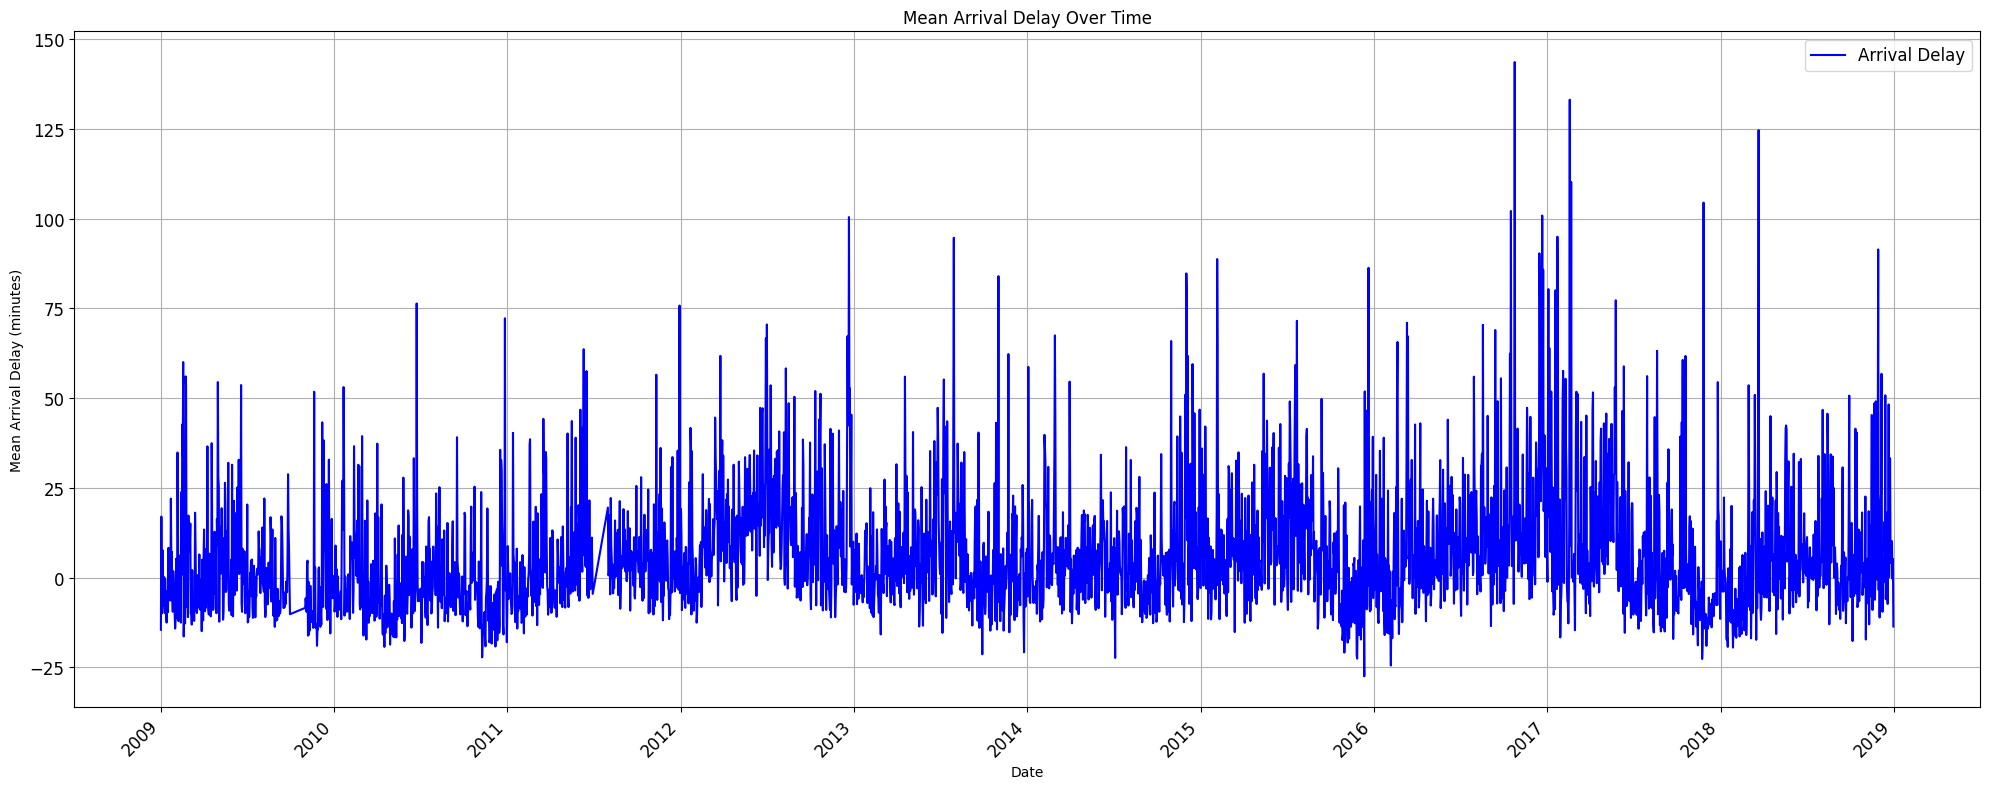

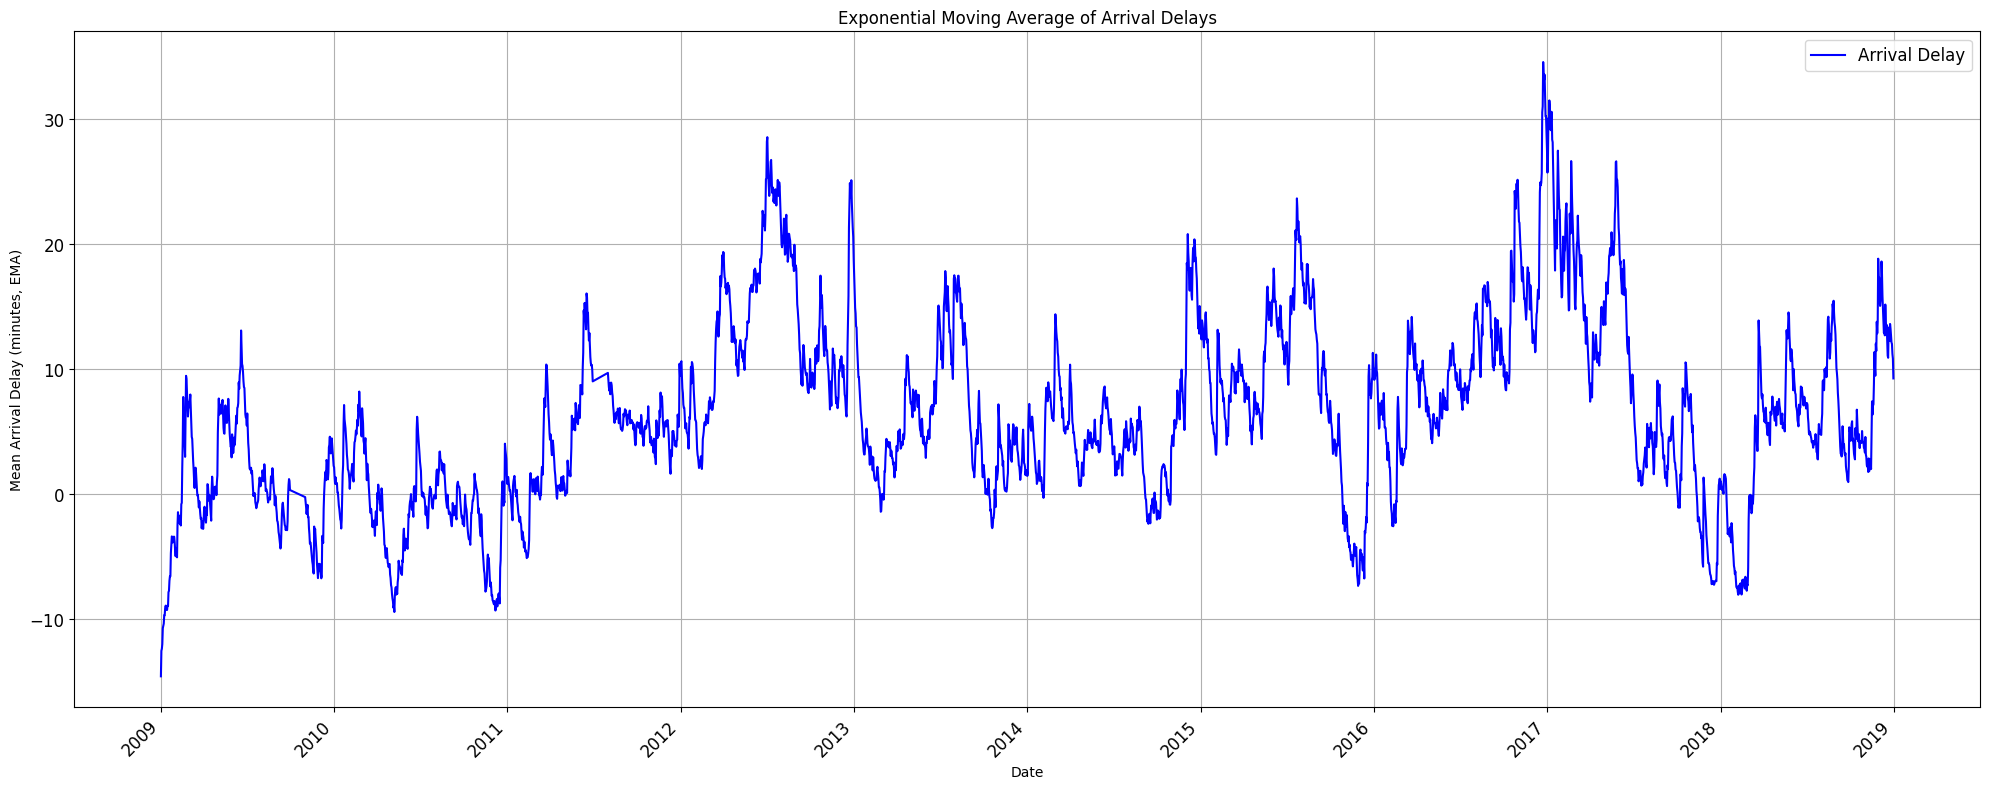

In [8]:
# Grafico del ritardo totale nel tempo (partenza e arrivo)
daily_analysis["AVG_ARR_DELAY"].plot(
    figsize=(20, 8), linestyle='-', color='b', 
    title="Mean Arrival Delay Over Time", grid=True, 
    xlabel="Date", ylabel="Mean Arrival Delay (minutes)", label="Arrival Delay"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

daily_analysis["EMA_ARR_DELAY"].plot(
    figsize=(20, 8), linestyle='-', color='b', 
    title="Exponential Moving Average of Arrival Delays", grid=True, 
    xlabel="Date", ylabel="Mean Arrival Delay (minutes, EMA)", label="Arrival Delay"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
# Creare un range di date che va dalla prima alla ultima data
date_range = pd.date_range(start=daily_analysis.index.min(), end=daily_analysis.index.max(), freq='D')

# Confrontare il range con l'indice delle date nel dataframe
missing_dates = date_range.difference(daily_analysis.index)

# Visualizzare le date mancanti
print(missing_dates)

DatetimeIndex(['2009-10-01', '2009-10-02', '2009-10-03', '2009-10-04',
               '2009-10-05', '2009-10-06', '2009-10-07', '2009-10-08',
               '2009-10-09', '2009-10-10', '2009-10-11', '2009-10-12',
               '2009-10-13', '2009-10-14', '2009-10-15', '2009-10-16',
               '2009-10-17', '2009-10-18', '2009-10-19', '2009-10-20',
               '2009-10-21', '2009-10-22', '2009-10-23', '2009-10-24',
               '2009-10-25', '2009-10-26', '2009-10-27', '2009-10-28',
               '2009-10-29', '2009-10-30', '2009-10-31', '2011-07-01',
               '2011-07-02', '2011-07-03', '2011-07-04', '2011-07-05',
               '2011-07-06', '2011-07-07', '2011-07-08', '2011-07-09',
               '2011-07-10', '2011-07-11', '2011-07-12', '2011-07-13',
               '2011-07-14', '2011-07-15', '2011-07-16', '2011-07-17',
               '2011-07-18', '2011-07-19', '2011-07-20', '2011-07-21',
               '2011-07-22', '2011-07-23', '2011-07-24', '2011-07-25',
      

In [10]:
# Creare un nuovo dataframe con tutte le date
all_dates_df = pd.DataFrame(index=date_range)

# Unire il dataframe con daily_analysis per includere anche le date mancanti
daily_analysis_full = all_dates_df.join(daily_analysis, how='left')

# Interpolare i valori mancanti in base al tempo
daily_analysis_full_interpolated = daily_analysis_full.interpolate(method='time')

# Visualizzare il risultato
print(daily_analysis_full_interpolated)

            AVG_DEP_DELAY  AVG_ARR_DELAY  AVG_AIR_TIME  NUM_FLIGHTS  \
2009-01-01      -0.727273     -14.545455     54.454545         11.0   
2009-01-02      26.230769      17.000000     54.153846         13.0   
2009-01-03       0.083333     -10.000000     56.333333         12.0   
2009-01-04      10.125000      -6.437500     53.375000         16.0   
2009-01-05      19.266667       7.600000     50.533333         15.0   
...                   ...            ...           ...          ...   
2018-12-27       6.500000       4.666667     52.000000         12.0   
2018-12-28      12.833333      10.166667     54.833333         12.0   
2018-12-29       5.000000      -0.333333     55.000000          9.0   
2018-12-30       9.083333       5.250000     52.333333         12.0   
2018-12-31      -2.000000     -13.625000     51.375000          8.0   

            EMA_ARR_DELAY  
2009-01-01     -14.545455  
2009-01-02     -12.510264  
2009-01-03     -12.348311  
2009-01-04     -11.966969  
2009-01

## Arrival Delay

<Axes: >

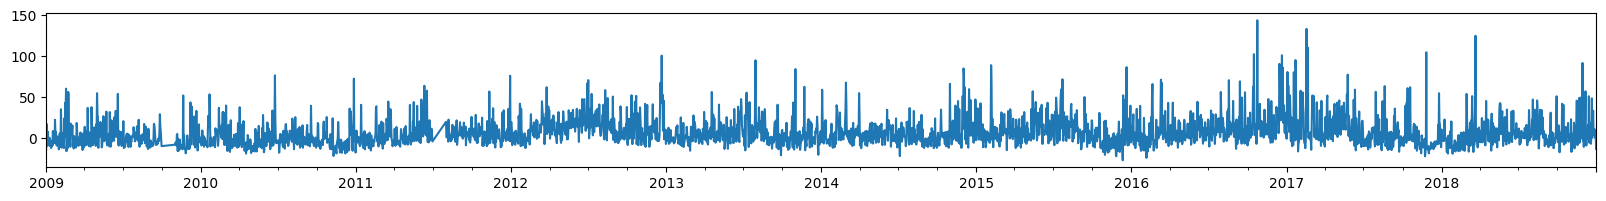

In [11]:
daily_analysis_arr = daily_analysis_full_interpolated['AVG_ARR_DELAY']
# Creare un intervallo completo di date che copra tutte le date nel dataset
full_index = pd.date_range(start=daily_analysis.index[0], end=daily_analysis.index[-1], freq='D')

# Allineare daily_analysis_arr con il nuovo indice completo
daily_analysis_arr = daily_analysis['AVG_ARR_DELAY'].reindex(full_index)

# Gestire i valori mancanti (NaN) con interpolazione, propagazione, o riempiendo con 0
daily_analysis_arr.interpolate(method='time', inplace=True)  # Interpolazione lineare basata sul tempo

daily_analysis_arr.plot(figsize=(20, 2))


### Stazionarietà

In [12]:
X = daily_analysis_arr.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.191371
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Stagionalità, trend e residui

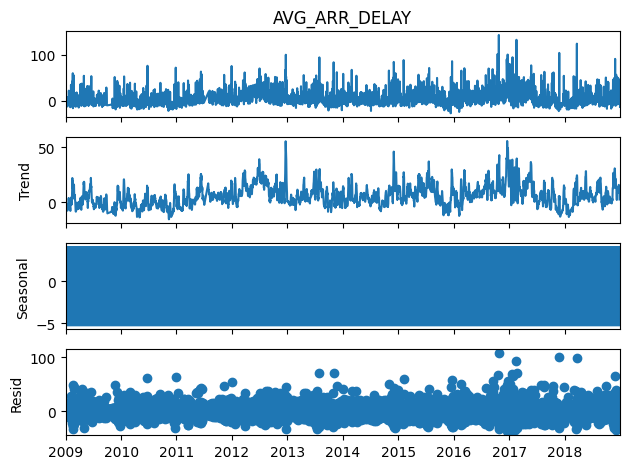

In [13]:
# Perform seasonal decomposition
dec2 = seasonal_decompose(daily_analysis_arr.asfreq('D').interpolate('linear'), model='additive')
dec2.plot()
plt.show()


### Autocorrelazione Parziale e Autocorrelazione

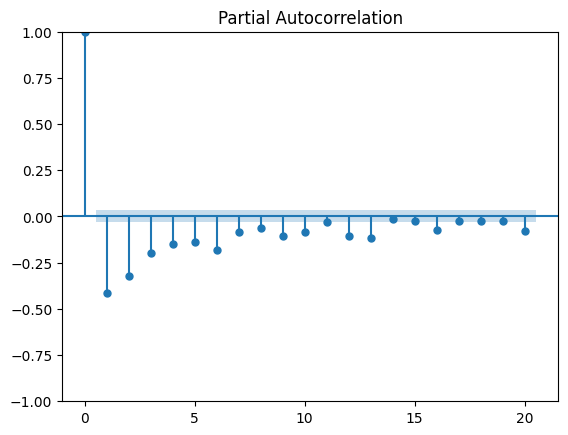

In [14]:
sm.graphics.tsa.plot_pacf(daily_analysis_arr.diff().dropna(), lags=20, method="ywm")
plt.show()

In [15]:
# Calcolo delle differenze
diff = daily_analysis_arr.diff().dropna()

# Calcolo dei valori di PACF per 20 lag
pacf_values = pacf(diff, nlags=20, method="ywm")

# Conta i valori superiori a 0.1 o inferiori a -0.1 (zona di confidenza)
count_above_01 = (pacf_values > 0.1).sum()
count_below_01 = (pacf_values < -0.1).sum()

print(f"Numero di valori PACF superiori a 0.1 nei primi 20 lag: {count_above_01}")
print(f"Numero di valori PACF inferiori a -0.1 nei primi 20 lag: {count_below_01}")

Numero di valori PACF superiori a 0.1 nei primi 20 lag: 1
Numero di valori PACF inferiori a -0.1 nei primi 20 lag: 9


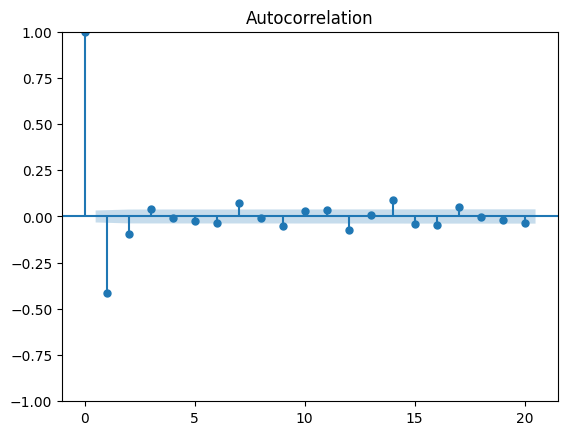

In [16]:
sm.graphics.tsa.plot_acf(daily_analysis_arr.diff().dropna(), lags=20)
plt.show()

In [17]:
# Calcolo delle differenze
diff = daily_analysis_arr.diff().dropna()

# Calcolo dei valori di autocorrelazione per 40 lag
acf_values = acf(diff, nlags=20)

# Conta i valori superiori a 0.1 o inferiori a -0.1 (zona di confidenza)
count_above_01 = (acf_values > 0.1).sum()
count_below_01 = (acf_values < -0.1).sum()

print(f"Numero di autocorrelazioni superiori a 0.1 nei primi 20 lag: {count_above_01}")
print(f"Numero di autocorrelazioni inferiori a -0.1 nei primi 20 lag: {count_below_01}")


Numero di autocorrelazioni superiori a 0.1 nei primi 20 lag: 1
Numero di autocorrelazioni inferiori a -0.1 nei primi 20 lag: 1


### Prediction

In [18]:
# Numero di osservazioni nel dataset
nobs = len(daily_analysis_arr)

# Calcolo dell'indice di separazione per il training set (80% dei dati)
n_init_training = int(nobs * 0.8)

# Separazione dei dati in training e test set
training_data = daily_analysis_arr[:n_init_training]
test_data = daily_analysis_arr[(n_init_training-1):]

In [19]:
# Serie temporale: dati
model = auto_arima(training_data, seasonal=False, trace=True)

# Sommario del modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23985.223, Time=2.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25320.205, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24786.415, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24074.289, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25318.206, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23978.564, Time=4.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23987.934, Time=1.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23981.512, Time=1.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23969.417, Time=9.53 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=23986.517, Time=2.85 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=23972.715, Time=9.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=23971.184, Time=10.94 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=23974.693, Time=6.48 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=23973.370, Time=13.53 sec
 ARIMA(1,1,3)(0,0

In [20]:
model = ARIMA(training_data, order=(2, 0, 2))

'''
MIGLIORE NONOSTANTE MAPE PIù ALTO
MAPE: 2.6138299078005507
MAE: 4.664829916578216
MSE: 36.58294735507071
R2: 0.4456290474516482
'''


'\nMIGLIORE NONOSTANTE MAPE PIù ALTO\nMAPE: 2.6138299078005507\nMAE: 4.664829916578216\nMSE: 36.58294735507071\nR2: 0.4456290474516482\n'

In [21]:
# Applichiamo auto_arima per selezionare automaticamente i parametri
model = auto_arima(training_data, seasonal=True, m=2, stepwise=True, trace=True)

# Sommario del modello trovato
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=23984.018, Time=5.02 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=25320.205, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=24380.926, Time=1.64 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=24076.252, Time=2.70 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=25318.206, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=23983.179, Time=3.08 sec
 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=23981.512, Time=1.93 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=23983.166, Time=2.65 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=24074.289, Time=1.26 sec
 ARIMA(1,1,0)(0,0,0)[2] intercept   : AIC=24786.415, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[2]             : AIC=23979.917, Time=0.84 sec
 ARIMA(1,1,1)(1,0,0)[2]             : AIC=23981.579, Time=1.41 sec
 ARIMA(1,1,1)(0,0,1)[2]             : AIC=23981.592, Time=1.76 sec
 ARIMA(1,1,1)(1,0,1)[2]             : AIC=23982.470, Time=2.87 sec
 ARIMA(0,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2921
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -11986.958
Date:                Thu, 13 Feb 2025   AIC                          23979.917
Time:                        10:07:47   BIC                          23997.855
Sample:                    01-01-2009   HQIC                         23986.378
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2067      0.016     12.975      0.000       0.175       0.238
ma.L1         -0.9548      0.006   -170.997      0.000      -0.966      -0.944
sigma2       215.2312      2.910     73.956      0.000     209.527     220.935
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              6014.73
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             1.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
model = SARIMAX(training_data, order=(2, 0, 2), seasonal_order=(2, 0, 3, 12))

'''
MAPE: 1.615879216103319
MAE: 5.084337275965445 
SQE: 38.922325350061165 
R2: 0.410178562971377
'''



'\nMAPE: 1.615879216103319\nMAE: 5.084337275965445 \nSQE: 38.922325350061165 \nR2: 0.410178562971377\n'

In [23]:
model_fit = model.fit()

# Forecast the fitted values
forecast = model_fit.fittedvalues

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                              AVG_ARR_DELAY   No. Observations:                 2921
Model:             SARIMAX(2, 0, 2)x(2, 0, [1, 2, 3], 12)   Log Likelihood              -11984.244
Date:                                    Thu, 13 Feb 2025   AIC                          23988.488
Time:                                            10:10:24   BIC                          24048.285
Sample:                                        01-01-2009   HQIC                         24010.026
                                             - 12-30-2016                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3098      0.061     21.360      0.000       1.190       1.430
ar.L2         -0.3161      0.059     -5.315      0.000      -0.433      -0.200
ma.L1         -1.0692      0.060    -17.721      0.000      -1.188      -0.951
ma.L2          0.1219      0.052      2.328      0.020       0.019       0.224
ar.S.L12       0.0180      0.031      0.589      0.556      -0.042       0.078
ar.S.L24       0.9809      0.035     28.116      0.000       0.912       1.049
ma.S.L12      -0.0669      0.038     -1.782      0.075      -0.141       0.007
ma.S.L24      -0.9827      0.039    -25.271      0.000      -1.059      -0.906
ma.S.L36       0.0534      0.019      2.857      0.004       0.017       0.090
sigma2       213.0621      3.776     56.424      0.000     205.661     220.463
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6037.51
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             1.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

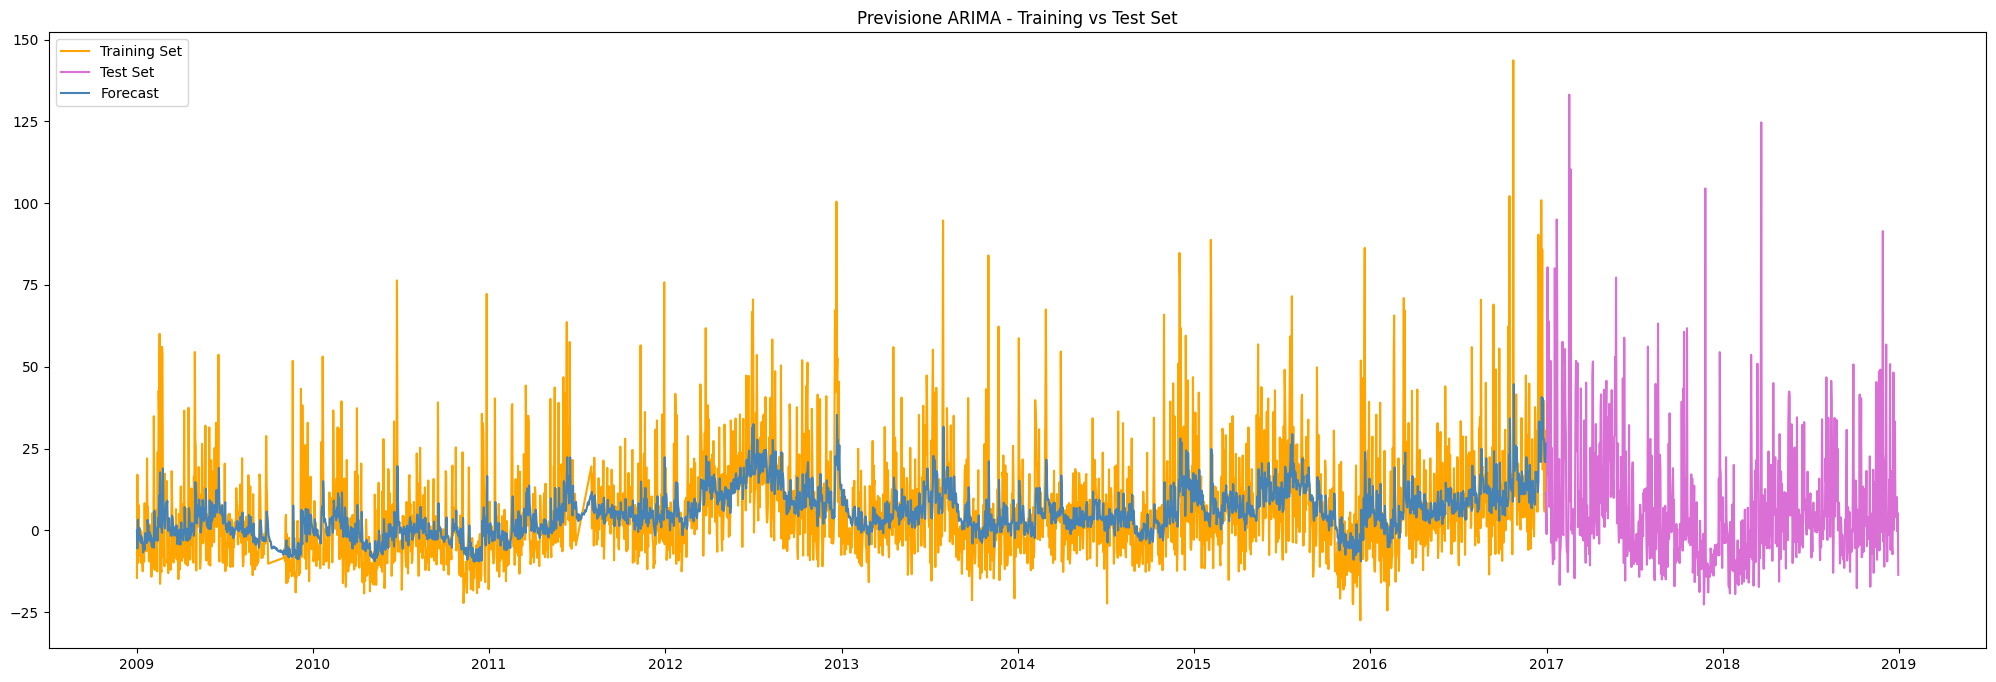

                                         SARIMAX Results                                          
Dep. Variable:                              AVG_ARR_DELAY   No. Observations:                 2921
Model:             SARIMAX(2, 0, 2)x(2, 0, [1, 2, 3], 12)   Log Likelihood              -11984.244
Date:                                    Thu, 13 Feb 2025   AIC                          23988.488
Time:                                            10:10:25   BIC                          24048.285
Sample:                                        01-01-2009   HQIC                         24010.026
                                             - 12-30-2016                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3098      0.061     21.360      0

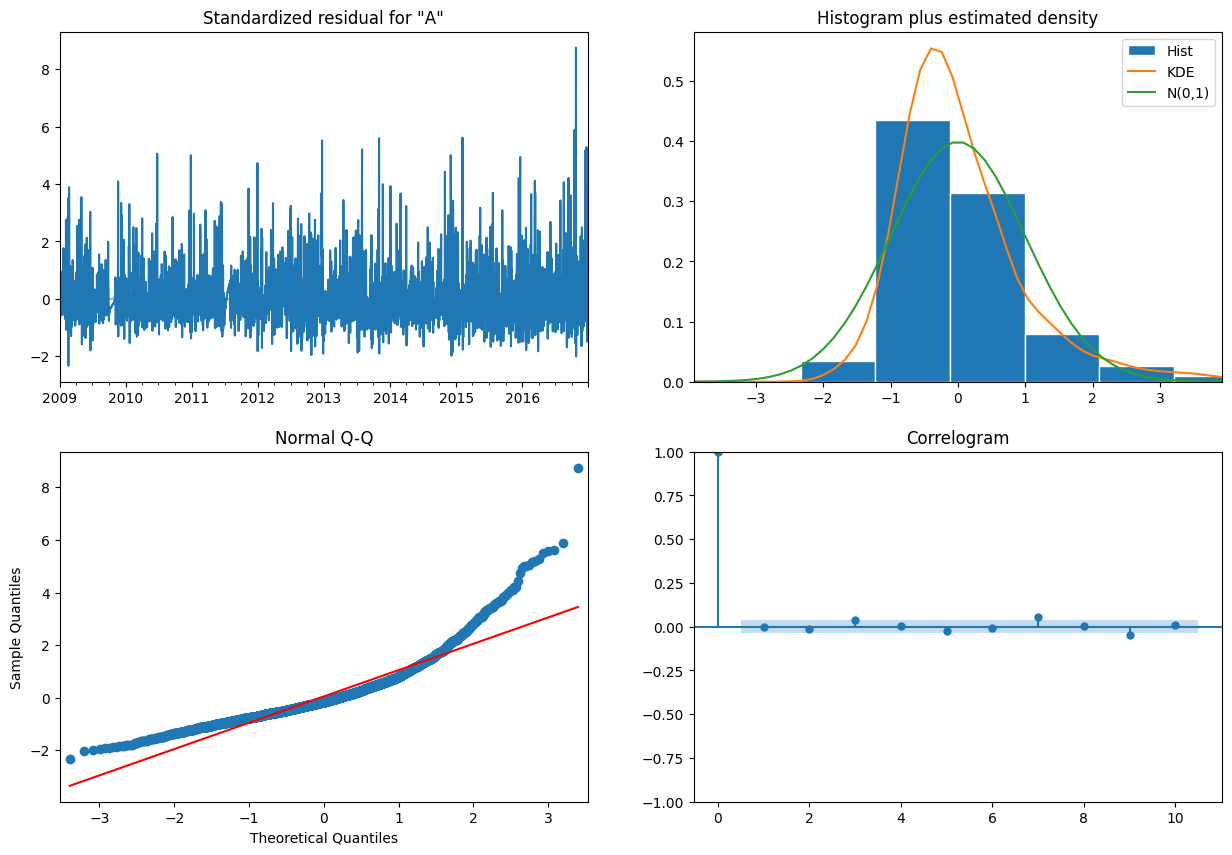

In [24]:
# Visualizzazione dei risultati
fig, ax = plt.subplots(figsize=(25, 8))

# Grafico dei dati
ax.plot(training_data, color='orange', label='Training Set')  
ax.plot(test_data, color='orchid', label='Test Set')  
ax.plot(forecast, color='steelblue', label='Forecast')  

# Aggiunta della legenda e del titolo
ax.legend(loc='upper left')
ax.set_title('Previsione ARIMA - Training vs Test Set')

# Mostra il grafico
plt.show()

# Stampa del sommario dei risultati del modello
print(model_fit.summary())

# Dettagli aggiuntivi sul periodo considerato
print(f"Numero di elementi nel periodo: {nobs}")
print(f"Indice dell'ultimo elemento del training set: {n_init_training}")

# Diagnostica dei residui
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()


### Predizione

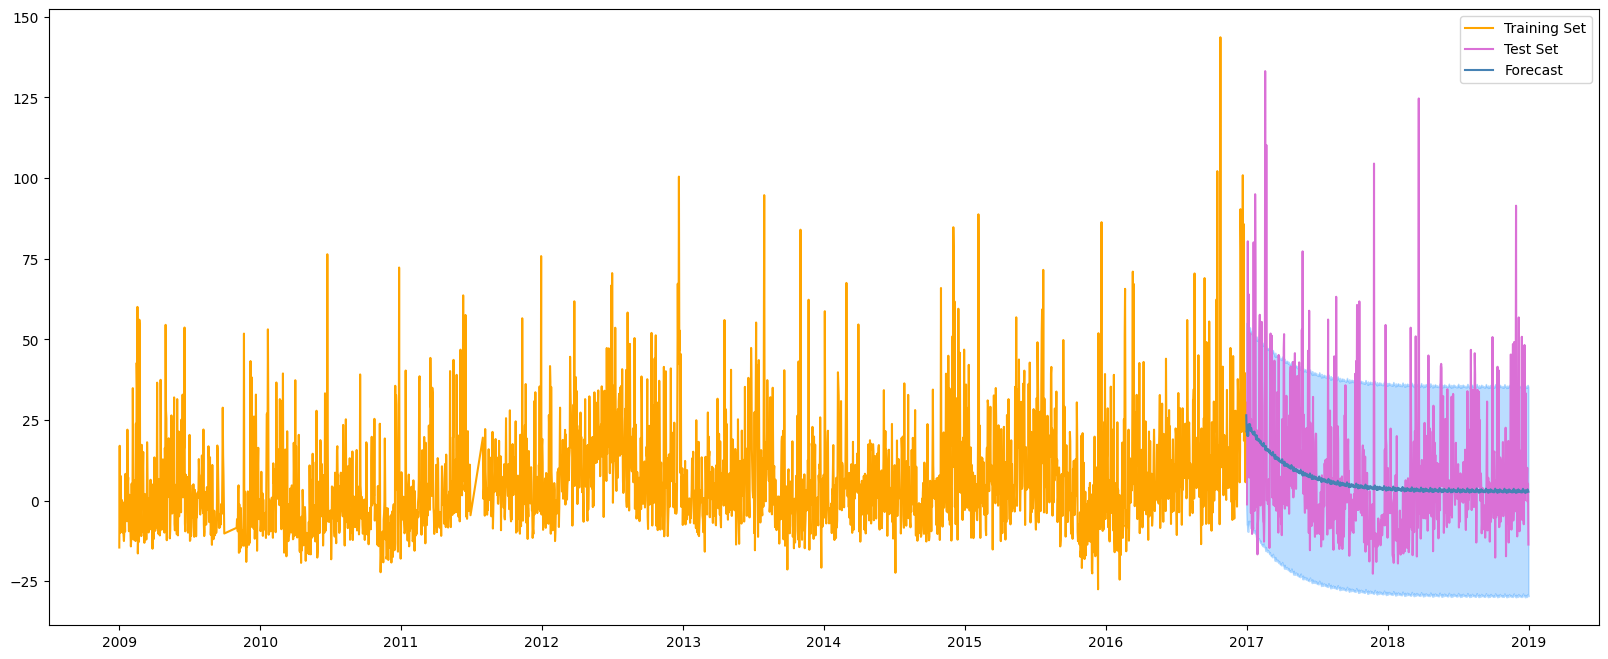

AVG_ARR_DELAY,mean,mean_se,mean_ci_lower,mean_ci_upper
2016-12-30,26.465234,14.600587,-2.151392,55.081859
2016-12-31,21.241570,14.600587,-7.375056,49.858195
2017-01-01,21.776135,15.017092,-7.656824,51.209094
2017-01-02,20.050971,15.120332,-9.584336,49.686278
2017-01-03,22.290635,15.167883,-7.437870,52.019140
...,...,...,...,...
2018-12-27,2.548176,16.547987,-29.885282,34.981634
2018-12-28,3.251114,16.547963,-29.182299,35.684526
2018-12-29,3.467553,16.547967,-28.965866,35.900972
2018-12-30,3.208507,16.547970,-29.224918,35.641933


In [25]:
'''GRAFICO ARIMA'''

x = model_fit.get_prediction(
    start=test_data.index[0], 
    end=test_data.index[-1], 
).summary_frame()

# Grafico aggiornato
plt.figure(figsize=(20, 8))
plt.plot(training_data, color='orange')
plt.plot(daily_analysis_arr[n_init_training + 1:], color='orchid')
plt.plot(x['mean'], color='steelblue')
plt.legend(['Training Set', 'Test Set', 'Forecast'])
plt.fill_between(x.index, x['mean_ci_lower'], x['mean_ci_upper'], color='dodgerblue', alpha=0.3)
plt.show()

x


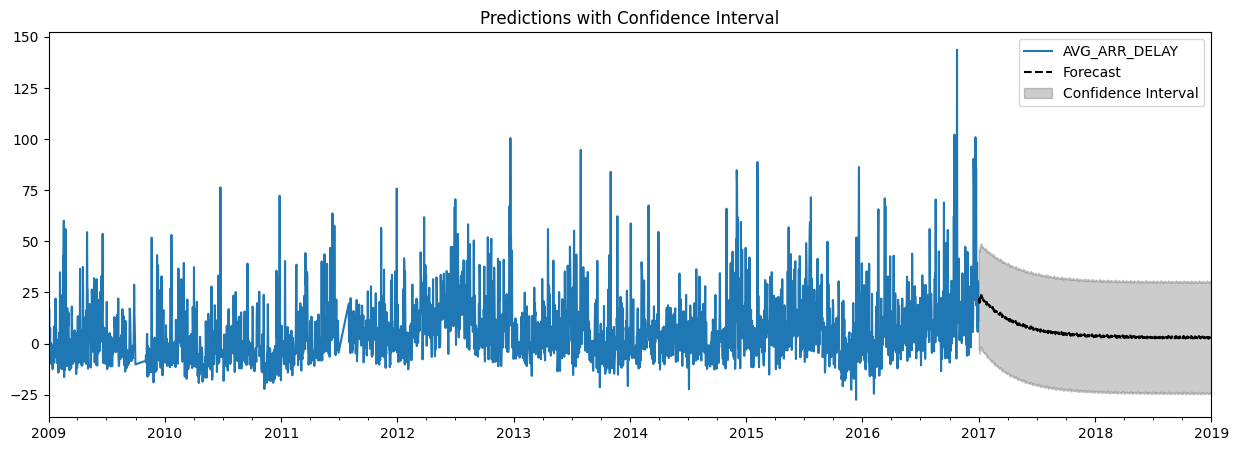

In [26]:
'''GRAFICO ARIMA'''

forecast = model_fit.get_forecast(steps=len(test_data))
fcast = forecast.summary_frame(alpha=0.10)
forecast_idx = pd.date_range(start=training_data.index[-1] + pd.Timedelta(days=1), periods=len(test_data), freq='D')
fcast.index = forecast_idx

# Grafico
fig, ax = plt.subplots(figsize=(15, 5))
training_data[0:].plot(ax=ax)
fcast['mean'].plot(ax=ax, style='k--', label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Predictions with Confidence Interval")
plt.show()


In [27]:
y_actual = daily_analysis_arr[test_data.index[0]:]
y_predicted = x['mean']

# Calculate MAPE
mape = met.mean_absolute_percentage_error(y_actual, y_predicted)
print('MAPE:', mape)

# Calculate MAE
mae = met.mean_absolute_error(y_actual, y_predicted)
print('MAE:', mae)

# Calculate SQE (Mean Squared Error)
mse = met.mean_squared_error(y_actual, y_predicted)
print('MSE:', mse)

# Calculate R2 score
r2 = met.r2_score(y_actual, y_predicted)
print('R2:', r2)


MAPE: 38765100063429.46
MAE: 13.397504057412615
MSE: 368.9516877024446
R2: 0.04958307742239587


### Out-sample prediciton

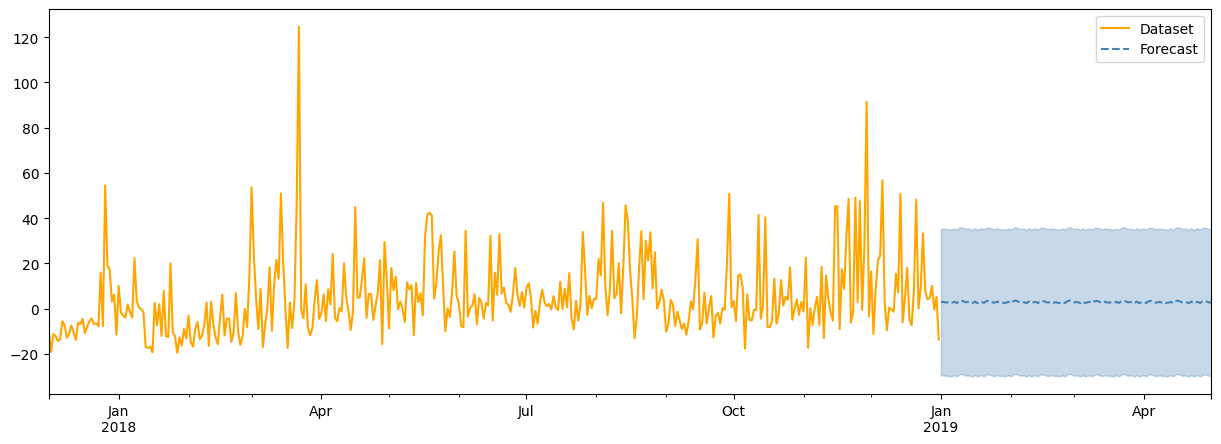

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
daily_analysis_arr['2017-12-01':].plot(ax=ax, color='orange')

# Construct the forecasts
fcast = model_fit.get_prediction(start=(nobs), end=(nobs+120)).summary_frame()
fcast['mean'].plot(ax=ax, style='--', color='steelblue')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='steelblue', alpha=0.3)
ax.legend(['Dataset', 'Forecast'])